In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge WNTR

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ubuntu/anaconda3/envs/tensorflow_p36

  added / updated specs: 
    - wntr


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2t             |       h14c3975_0         3.1 MB  conda-forge
    retrying-1.3.3             |             py_2          11 KB  conda-forge
    plotly-4.2.1               |             py_0         4.1 MB  conda-forge
    wntr-0.2.1                 |   py36h9de70de_3         2.7 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    -----------------------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

casadi could not be imported


# Data Pre-Processing

Get clusters:

In [5]:
cluster_labels = pd.read_json('cluster_labels_dt1h.json')
pressure_factor = pd.read_json('pressure_factor_dt1h.json')
n_clusters = 30

Get results:

In [6]:
data_path = '/home/ubuntu/gitrepos/Results/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/wntr/epanet/io.py:2085: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



## Normalize Data:

Scaling factors:

In [7]:
input_scaling = pd.concat(nn_input_list).abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5

output_scaling = pd.concat(nn_output_list).abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5

In [8]:
nn_input_list_scaled = [nn_in_i/input_scaling for nn_in_i in nn_input_list]
nn_output_list_scaled = [nn_out_i/output_scaling for nn_out_i in nn_output_list]

In [9]:
input_scaling = input_scaling.to_numpy().reshape(1,-1)
output_scaling = output_scaling.to_numpy().reshape(1,-1)

## RNN I/O structure

In [10]:
n_datasets = len(file_list)-10
seq_length = 20  # length of sequence for ANN training

n_data = nn_input_list[0].shape[0]
n_seq = n_data // seq_length - 1

# create sequences from the data:
X = []
Y = []
for data_i in range(n_datasets):
    X_train = nn_input_list_scaled[data_i].to_numpy()
    Y_train = nn_output_list_scaled[data_i].to_numpy()
    for offset in range(n_seq):
        for data_sample in range(n_seq):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :])
            Y.append(Y_train[start_ind:start_ind + seq_length, :])

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = n_seq*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [12]:
ny

42

In [52]:
# seq_length = 20  # length of sequence for ANN training
# X_train = nn_input_list[0].to_numpy()
# Y_train = nn_output_list[0].to_numpy()

# # create sequences from the data:
# X = []
# Y = []

# n_data = X_train.shape[0]
# n_seq = n_data // seq_length - 1


# for offset in range(n_seq):
#     for data_sample in range(n_seq):
#         start_ind = data_sample*seq_length+offset
#         X.append(X_train[start_ind:start_ind + seq_length, :])
#         Y.append(Y_train[start_ind:start_ind + seq_length, :])

# X = np.stack(X, axis=0)  # [m, seq_length, nx]
# Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

# batch_size = n_seq
# nx = X.shape[2]
# ny = Y.shape[2]

In [53]:
# If batch_size > 1 and stateful mode active, the order of the elements has to be adapted.
# batch_size = 5
# n_batches = X.shape[0]//batch_size
# n_data_red = batch_size*n_batches
# batch_ind = np.arange(n_data_red).reshape(-1, n_batches).T.ravel()

# X = X[batch_ind, :, :]
# Y = Y[batch_ind, :, :]

# nx = X.shape[2]
# ny = Y.shape[2]

# Create RNN

In [105]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.compile(loss='mse', optimizer='Adam')
model.summary()

No value selected for dropout, choosing do=0.
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (768, 20, 40)             18720     
_________________________________________________________________
time_distributed_33 (TimeDis (768, 20, 40)             1640      
_________________________________________________________________
dropout_22 (Dropout)         (768, 20, 40)             0         
_________________________________________________________________
time_distributed_34 (TimeDis (768, 20, 40)             1640      
_________________________________________________________________
dropout_23 (Dropout)         (768, 20, 40)             0         
_________________________________________________________________
time_distributed_35 (TimeDis (768, 20, 42)             1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
___

In [147]:
if stateful:
    cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())
else:
    cb_reset = keras.callbacks.LambdaCallback()

cb_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-7, patience=10, mode='min')
model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=1000, verbose=1, shuffle=not(stateful))

Epoch 1/1000
6144/6144 [==============================] - 0s 27us/sample - loss: 0.0027
Epoch 2/1000
6144/6144 [==============================] - 0s 25us/sample - loss: 0.0021
Epoch 3/1000
6144/6144 [==============================] - 0s 23us/sample - loss: 0.0020
Epoch 4/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0020
Epoch 5/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0021
Epoch 6/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0021
Epoch 7/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0020
Epoch 8/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0020
Epoch 9/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0020
Epoch 10/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0020
Epoch 11/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 12/1000
6144/6144 [=====

6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 94/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 95/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 96/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 97/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 98/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 99/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 100/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 101/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 102/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 103/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 104/1000
6144/6144 [=====

6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 276/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 277/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 278/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 279/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 280/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 281/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 282/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 283/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 284/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 285/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 286/1000
6144/6144 

6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 458/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 459/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 460/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 461/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 462/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 463/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 464/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 465/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 466/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 467/1000
6144/6144 [==============================] - 0s 23us/sample - loss: 0.0019
Epoch 468/1000
6144/6144 

6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 640/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 641/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 642/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 643/1000
6144/6144 [==============================] - 0s 23us/sample - loss: 0.0019
Epoch 644/1000
6144/6144 [==============================] - 0s 23us/sample - loss: 0.0019
Epoch 645/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 646/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 647/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 648/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 649/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 650/1000
6144/6144 

6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 822/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 823/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 824/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 825/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 826/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 827/1000
6144/6144 [==============================] - 0s 22us/sample - loss: 0.0019
Epoch 828/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 829/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 830/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 831/1000
6144/6144 [==============================] - 0s 21us/sample - loss: 0.0019
Epoch 832/1000
6144/6144 

In [157]:
model.save('./Models/manual_01.h5')

# Evaluate Model

In [148]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (1, 1, 40)                18720     
_________________________________________________________________
time_distributed_48 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
dropout_32 (Dropout)         (1, 1, 40)                0         
_________________________________________________________________
time_distributed_49 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
dropout_33 (Dropout)         (1, 1, 40)                0         
_________________________________________________________________
time_distributed_50 (TimeDis (1, 1, 42)                1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
___

Initialize hidden state:

In [153]:
model_simple.reset_states()
test_with = 20
nn_input = nn_input_list_scaled[test_with]
sys_states = nn_input_list[test_with]['sys_states']
sys_inputs = nn_input_list[test_with]['sys_inputs']
# Initialize hidden state:
t = 0
dt = 14400
for i,in_i in nn_input.iloc[:seq_length].iterrows():
    rnn_in_scaled = in_i.to_numpy().reshape(1,-1)
    model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    t += dt

In [154]:
x_arr = [sys_states.iloc[seq_length].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[seq_length:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(rnn_out[[0],:37])
    
res = np.concatenate(x_arr)

In [155]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

<IPython.core.display.Javascript object>


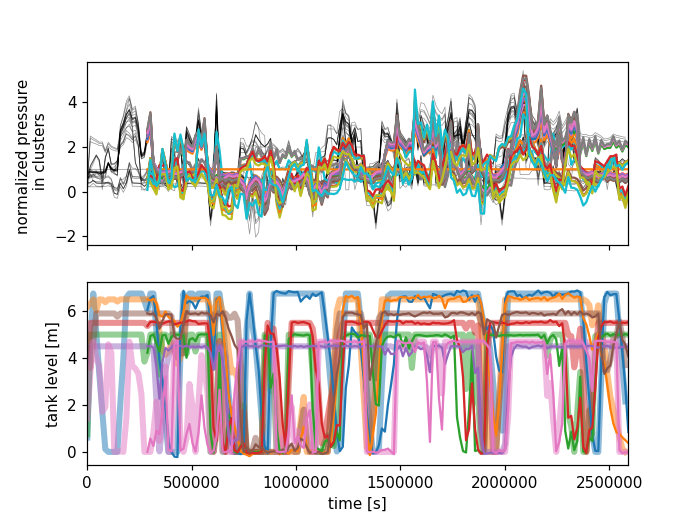

Text(0.5, 0, 'time [s]')

In [156]:
fig, ax = plt.subplots(2,1, sharex=True)

sys_states['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
res['tank_press'].plot(ax=ax[1], legend=False)

ax[0].set_xlim(0, res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Keras 2 Casadi

In [39]:
from casadi import *

In [58]:
config = model_simple.get_config()
weights = model_simple.get_weights()

In [61]:
x_cas_in = MX.sym('x', 1, 76)
h_cas_in = MX.sym('h', 1, 40)
c_cas_in = MX.sym('c', 1, 40)

[x_cas_out, h_cas_out, c_cas_out], _ = keras2casadi(
    weights, config['layers'], [x_cas_in, h_cas_in, c_cas_in], backend_name='casadi')
fun = Function('fun', [x_cas_in, h_cas_in, c_cas_in], [x_cas_out, h_cas_out, c_cas_out])

In [84]:
x = np.ones((1, 76))
h = np.zeros((1, 40))
c = np.zeros((1, 40))

In [80]:
x = np.ones((1, 76))
x,h,c = fun(x,h,c)

In [81]:
x.full()

array([[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
         0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]])

In [77]:
model_simple.reset_states()

In [82]:
x = np.ones((1, 76))
model_simple.predict(x.reshape(1,1,-1))

array([[[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
          0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]]], dtype=float32)

# Create Full Training Dataset
Load data (lists of pandas objects)

In [38]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:40]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

Convert to list of numpy arrays:

In [39]:
nn_input_np_list = [i.to_numpy() for i in nn_input_list]
nn_output_np_list = [i.to_numpy() for i in nn_output_list]

Concatenate in time dimension:

In [40]:
nn_input_concat = np.concatenate(nn_input_np_list,axis =0)
nn_output_concat = np.concatenate(nn_output_np_list,axis =0)

Normalize data:

1.) Get factors:

In [41]:
input_offset = nn_input_concat.mean(axis=0, keepdims=True)
nn_input_offset = nn_input_concat - input_offset
input_scaling = np.max(np.abs(nn_input_offset),axis=0, keepdims=True)
input_scaling = np.maximum(input_scaling, 1e-5)

output_offset = nn_output_concat.mean(axis=0, keepdims=True)
nn_output_offset = nn_output_concat - output_offset
output_scaling = np.max(np.abs(nn_output_offset),axis=0, keepdims=True)
output_scaling =  np.maximum(output_scaling, 1e-5)

2.) Apply to list:

In [42]:
nn_input_np_list_norm = [(i-input_offset)/input_scaling for i in nn_input_np_list]
nn_output_np_list_norm = [(i-output_offset)/output_scaling for i in nn_output_np_list]

Stack lists:

In [43]:
nn_input_stacked = np.stack(nn_input_np_list_norm, axis=0)
nn_output_stacked = np.stack(nn_output_np_list_norm, axis=0)

In [48]:
seq_length = 20  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = nn_input_stacked.shape[1]
n_seq = n_data // seq_length - 1



for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(nn_input_stacked[:,start_ind:start_ind + seq_length, :])
    Y.append(nn_output_stacked[:,start_ind:start_ind + seq_length, :])
    
X = np.concatenate(X, axis=0)  # [m, seq_length, nx]
Y = np.concatenate(Y, axis=0)  # [m, seq_length, ny]

In [49]:
batch_size=40
nx = X.shape[2]
ny = Y.shape[2]
X.shape

(1280, 20, 76)